# <center>FONCTION CARTOGRAPHIE</center> #

## <font color='#5BA69E'>INTRODUCTION</font> ##

Ce notebook a pour objectif de réaliser de multiples cartographies pour une variable de l'INSEE à définir par l'utilisateur.  
Le cadre est limité à la France métropolitaine et les DOM TOM sont donc exclus.

L'utilisateur doit disposer d'un fichier csv avec la ou les variables qu'il souhaite cartographier.  
Le fichier doit obligatoirement contenir les variables CODGEO, REG et DEP de l'INSEE au format 'string'.

## <font color='#5BA69E'>INSTRUCTIONS</font> ##

Commencez par déposer votre fichier csv dans le répertoire **files** (qui contient ce même notebook) puis renseignez le nom de fichier dans la variable ci-dessous. 

In [1]:
nom_dataset = 'variables_ets.csv'

Définissez la variable cible de votre dataset à cartographier (ex: salaire médian, nombre d'établissements.)

In [2]:
nom_variable = 'ets_total'

Définissez une aire d'attraction de ville comme focus.

In [3]:
aire_attraction = 'Rouen'

## <font color='#5BA69E'>IMPORT LIBRAIRIES</font> ##

In [4]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

## <font color='#5BA69E'>CHARTE GRAPHIQUE</font> ##

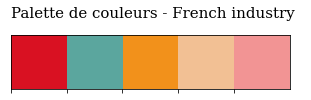

In [12]:
sns.palplot(["#D91122", "#5BA69E", "#F2911B", "#F2C094", "#F29494"])
plt.title("Palette de couleurs - French industry  ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

## FONCTION ##

In [21]:
data = pd.read_csv('../files/variables_ets.csv')
data.head()

C:\Users\vivie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CODGEO,LIBGEO,AAV2020,LIBAAV2020,CATEAAV2020,DEP,REG,niveau_vie_median,ets_total,ets_local,ets_externe,ets_impact_local_p,ets_impact,ets_creation,ent_creation,ets_creation_p,ets_industrie,ets_industrie_p,ets_effectif50p_p,ets_taille50p_p
0,01001,L'Abergement-Clémenciat,524,Châtillon-sur-Chalaronne,20,01,84,24820.0,14.0,9.0,5.0,64.3,local,12,11,85.7,0.0,0.0,0.0,0.0
1,01002,L'Abergement-de-Varey,000,Commune hors attraction des villes,30,01,84,23220.0,4.0,2.0,2.0,50.0,équilibré,3,3,75.0,0.0,0.0,0.0,0.0
2,01004,Ambérieu-en-Bugey,243,Ambérieu-en-Bugey,11,01,84,21070.0,586.0,462.0,124.0,78.8,local,192,176,32.8,31.0,5.3,21.0,3.6
3,01005,Ambérieux-en-Dombes,002,Lyon,20,01,84,24380.0,46.0,36.0,10.0,78.3,local,24,23,52.2,4.0,8.7,0.0,0.0
4,01006,Ambléon,286,Belley,20,01,84,NaN,2.0,1.0,1.0,50.0,équilibré,0,0,0.0,0.0,0.0,0.0,0.0


In [30]:
def carto_french_indus(nom_dataset, nom_variable, aire_attraction):
    gdf = geopandas.read_file('../files/fond_AAV2020_geo20_metro/zMetro.shp')
    data = pd.read_csv('../files/'+nom_dataset)
    #data = data.drop(['REG', 'DEP', 'CODGEO'], axis=1)
    #on s'assure que CODGEO, REG et DEP sont bien au format 'string'
    data[['CODGEO', 'DEP', 'REG']] = data[['CODGEO', 'DEP', 'REG']].astype('string')
    print(data.dtypes)
    display(data.head())
    display(data.REG.value_counts())
    """
    CODGEO_num = 0
    try:
        for codgeo in data.CODGEO:
            if isinstance(codgeo, (int, float)):
                CODGEO_num += 1 
        print('Nombre de CODGEO au mauvais format :', CODGEO_num)
    except:
        print('Colonne CODGEO introuvable')

    try:
        reg_num = 0
        for reg in data.REG:
            if isinstance(reg, (int, float)):
                reg_num += 1 
        print('Nombre de REG au mauvais format :', reg_num)
    except:
        print('Colonne REG introuvable')    
    
    try:
        dep_num = 0
        for dep in data.DEP:
            if isinstance(dep, (int, float)):
                dep_num += 1 
        print('Nombre de DEP au mauvais format :', dep_num)
    except:
        print('Colonne DEP introuvable')
        
    if CODGEO_num > 0 | reg_num > 0 | dep_num >0:
        return "Problème de format dans les variables CODGEO, REG ou DEP"
    """

In [31]:
carto_french_indus(nom_dataset, nom_variable, aire_attraction)

CODGEO                 string
LIBGEO                 object
AAV2020                object
LIBAAV2020             object
CATEAAV2020             int64
DEP                    string
REG                    string
niveau_vie_median     float64
ets_total             float64
ets_local             float64
ets_externe           float64
ets_impact_local_p    float64
ets_impact             object
ets_creation            int64
ent_creation            int64
ets_creation_p        float64
ets_industrie         float64
ets_industrie_p       float64
ets_effectif50p_p     float64
ets_taille50p_p       float64
dtype: object


C:\Users\vivie\AppData\Local\Temp/ipykernel_34404/2266193845.py:1: DtypeWarning: Columns (0,5) have mixed types.Specify dtype option on import or set low_memory=False.
  carto_french_indus(nom_dataset, nom_variable, aire_attraction)


,CODGEO,LIBGEO,AAV2020,LIBAAV2020,CATEAAV2020,DEP,REG,niveau_vie_median,ets_total,ets_local,ets_externe,ets_impact_local_p,ets_impact,ets_creation,ent_creation,ets_creation_p,ets_industrie,ets_industrie_p,ets_effectif50p_p,ets_taille50p_p
0,01001,L'Abergement-Clémenciat,524,Châtillon-sur-Chalaronne,20,01,84,24820.0,14.0,9.0,5.0,64.3,local,12,11,85.7,0.0,0.0,0.0,0.0
1,01002,L'Abergement-de-Varey,000,Commune hors attraction des villes,30,01,84,23220.0,4.0,2.0,2.0,50.0,équilibré,3,3,75.0,0.0,0.0,0.0,0.0
2,01004,Ambérieu-en-Bugey,243,Ambérieu-en-Bugey,11,01,84,21070.0,586.0,462.0,124.0,78.8,local,192,176,32.8,31.0,5.3,21.0,3.6
3,01005,Ambérieux-en-Dombes,002,Lyon,20,01,84,24380.0,46.0,36.0,10.0,78.3,local,24,23,52.2,4.0,8.7,0.0,0.0
4,01006,Ambléon,286,Belley,20,01,84,NaN,2.0,1.0,1.0,50.0,équilibré,0,0,0.0,0.0,0.0,0.0,0.0


44    5106
76    4418
75    4307
84    4019
32    3781
27    3683
28    2646
24    1755
11    1267
52    1235
53    1207
93     943
94     350
2       34
1       32
4       24
3       22
Name: REG, dtype: Int64